#### Implementing a REAL NVP model for toy dataset

Michael Albergo and Bohdan Kulchytskyy

In [203]:

%matplotlib inline
import torch
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import os
import datetime
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
#import palettable
import seaborn as sns

In [204]:
input_size = 2
n_layers = 6

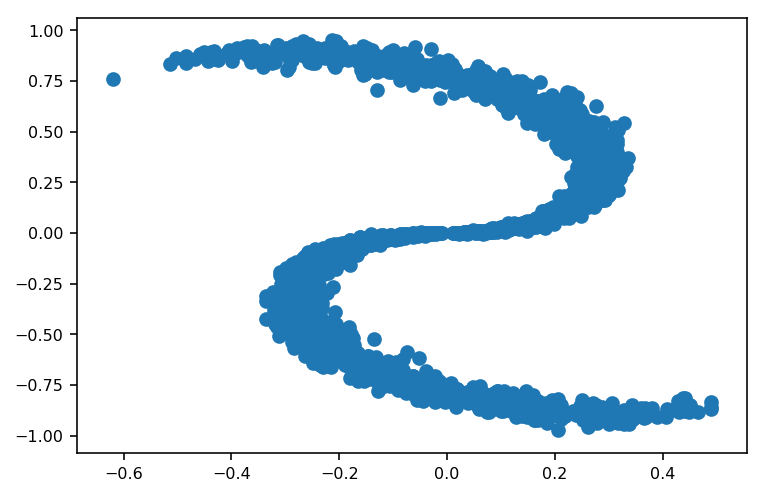

In [205]:
def real_sample(N = 100, K = 2):
    N_train = N*K # total number of points in the training set
    x_train = np.zeros((N_train,2)) # matrix containing the 2-dimensional datapoints
    y_train = np.zeros(N_train, dtype='uint8') # labels (not in one-hot representation)

    mag_noise = 0.08 # controls how much noise gets added to the data
    dTheta    = 2    # difference in theta in each branch

    ### Data generation: ###
    for j in range(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.01,1,N) # radius
        t = np.linspace(j*(2*np.pi)/K,j*(2*np.pi)/K + dTheta,N) + np.random.randn(N)*mag_noise # theta
        x_train[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
        
    return torch.from_numpy(x_train).double()

test = real_sample(N=1000)
plt.scatter(test[:, 0], test[:, 1], s=40)
plt.show()

In [210]:
class Coupling(nn.Module):
    def __init__(self, input_size):
        super(Coupling, self).__init__()
        
        self.input_size = input_size
        self.s = nn.Linear(input_size // 2, input_size // 2 )
        self.n_layers = n_layers
        
        self.s = torch.nn.ModuleList([torch.nn.Sequential(
                            torch.nn.Linear(input_size // 2, 35),
                            torch.nn.ReLU(),
                            torch.nn.Linear(35, 35),
                            torch.nn.ReLU(),
                            torch.nn.Linear(35, input_size // 2)) for i in range(n_layers)])
        self.t = torch.nn.ModuleList([torch.nn.Sequential(
                            torch.nn.Linear(input_size // 2, 35),
                            torch.nn.ReLU(),
                            torch.nn.Linear(35, 35),
                            torch.nn.ReLU(),
                            torch.nn.Linear(35, input_size // 2),
                            torch.nn.Tanh()) for i in range(n_layers)])
        
        self.perm = torch.randperm(input_size)
        self.prior = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))
        self.k = self.input_size // 2
        self.idx1 =  self.perm[:self.k]
        self.idx2 =  self.perm[self.k:]
        self.logjacdets = []
    
    def mask(self, x, perm, i ):
        
        k = x.size(1) // 2
        if i % 2 == 0:
            x1 = x[:,self.idx1]
            x2 = x[:,self.idx2]
        else:
            x1 = x[:,self.idx2]
            x2 = x[:,self.idx1]

        return x1, x2, self.idx1, self.idx2
    
    def re_sort(self, z1,z2, id1,id2):
        ids = torch.argsort(torch.cat((id1,id2),0))
        re_z = torch.cat((z1,z2), dim=1)
        z = re_z[:,ids]
        
        return z
    
    def logjacobian_det(self,x1,i):
        logdetjac = (torch.sum(self.s[i](x1),dim = 1))
        return logdetjac

    def func(self, x, i):
        #logjacdets = []
        x1, x2, id1, id2 = self.mask(x, self.perm, i )
        y1 = x1
        y2 = self.t[i](x1) + x2*torch.exp(self.s[i](x1))
        logjacdet = self.logjacobian_det(x1, i)
        self.logjacdets.append(logjacdet)
        y = self.re_sort(y1,y2, id1,id2)
        return y
    
    def inverse_func(self, z, i):
        z1, z2, id1, id2 = self.mask(z, self.perm, i)
        x1 = z2
        x2 = (z1 - self.t[-i](z2)) *torch.exp(- self.s[-i](z2))
        x = self.re_sort(x1,x2, id1,id2)
        return x
    
    def log_prob(self,z, logjacdets):
        
        return self.prior.log_prob(z) + sum(self.logjacdets)
    
    def forward(self, x):
        self.logjacdets = []
        for i in range(n_layers):
            if i == 0:
                z = self.func(x, i )
            else:
                z = self.func(z, i )
        logp = self.log_prob(z, self.logjacdets)
        return z, logp
    
    def sample(self, batchSize):
        decode = self.prior.sample((batchSize,))
        #x = self.inverse_func(z)
        for i in range(n_layers):
            if i == 0:
                x = self.inverse_func(decode, i )
            else:
                x = self.inverse_func(x, i )
        return x
        

model = Coupling(input_size=input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


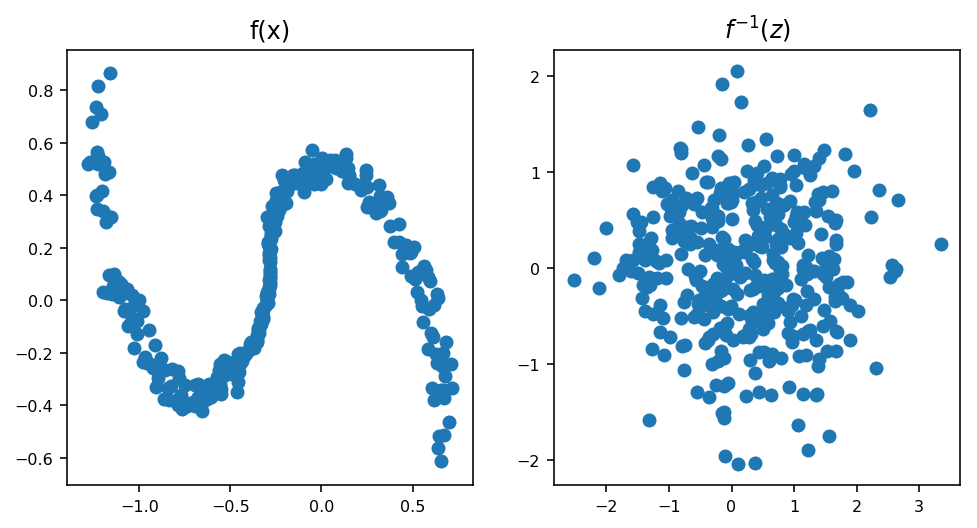

iter 0: loss = 1.731


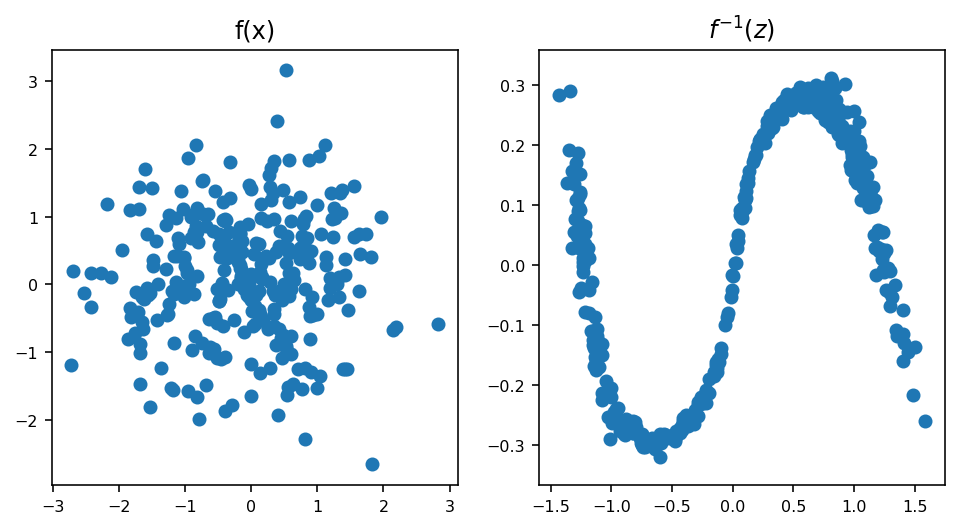

iter 500: loss = -1.217


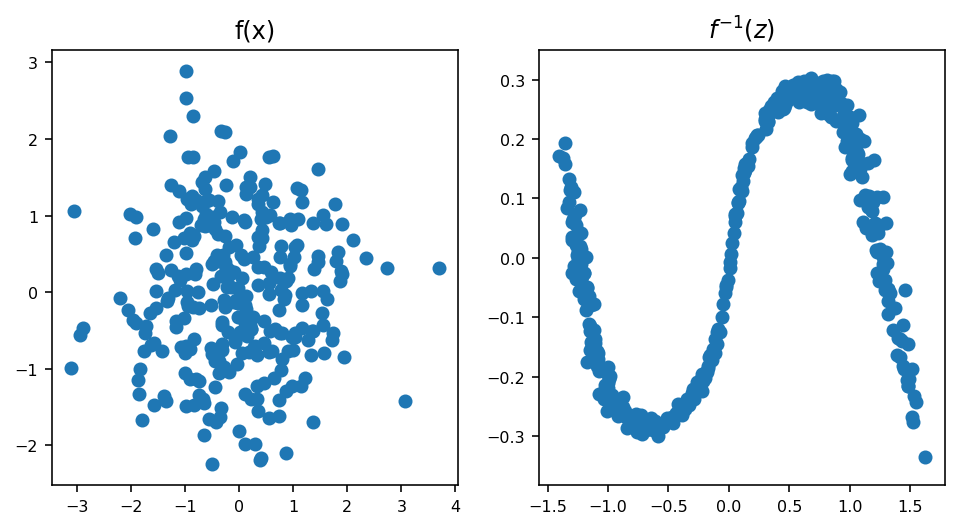

iter 1000: loss = -1.217


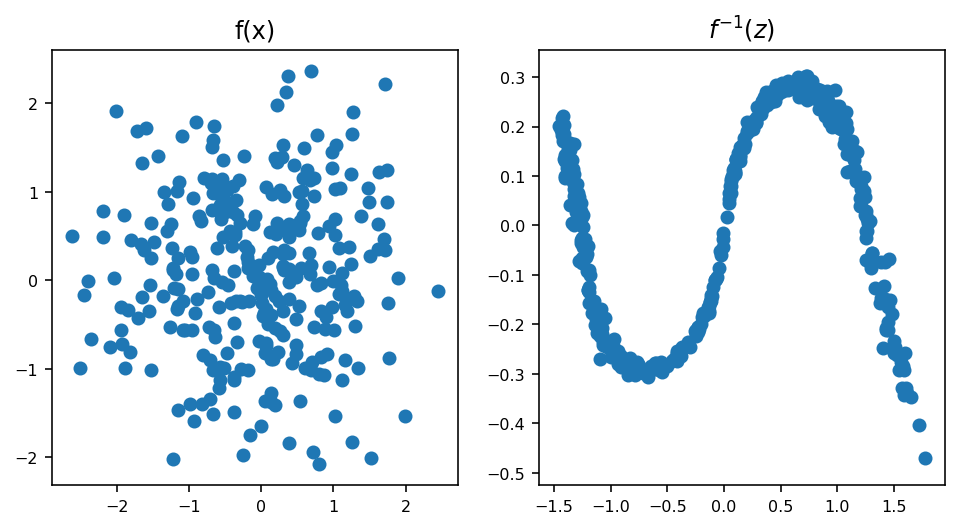

iter 1500: loss = -1.321


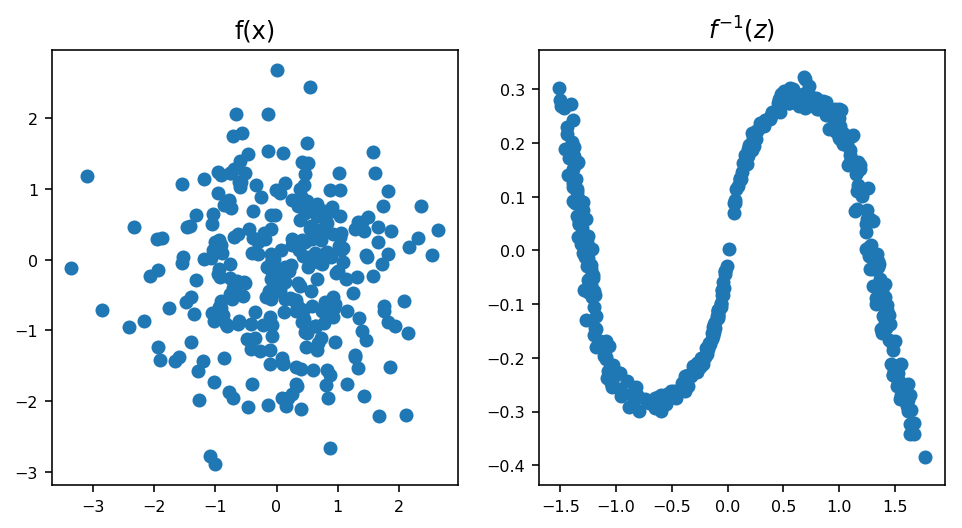

iter 2000: loss = -1.252


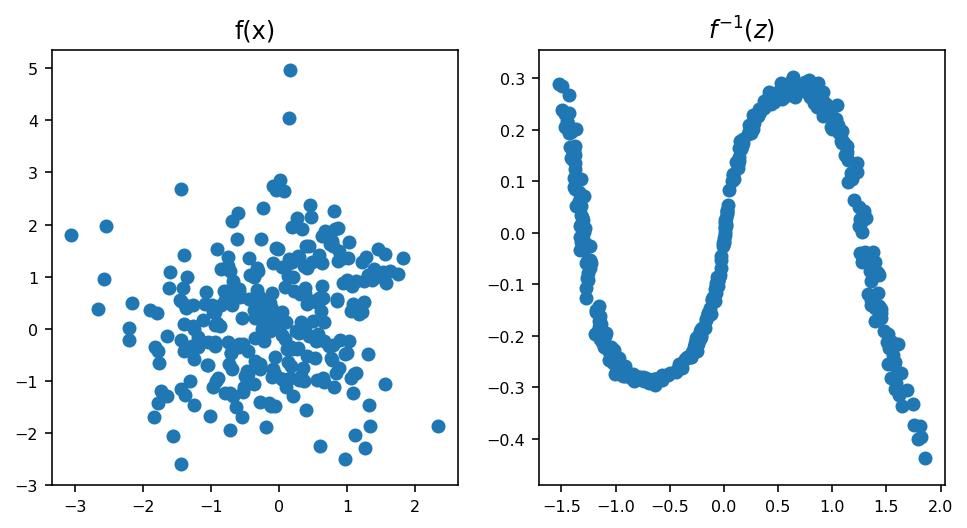

iter 2500: loss = -1.246


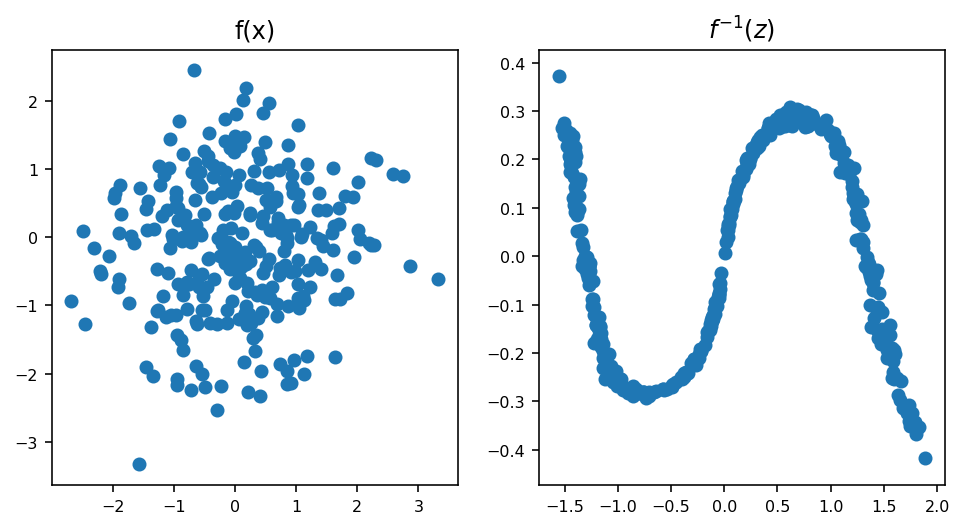

iter 3000: loss = -1.302


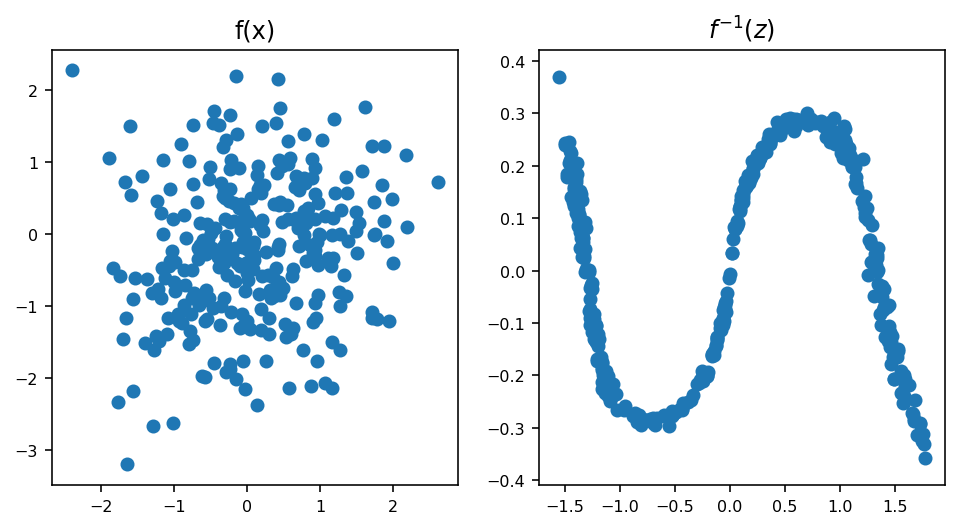

iter 3500: loss = -1.355


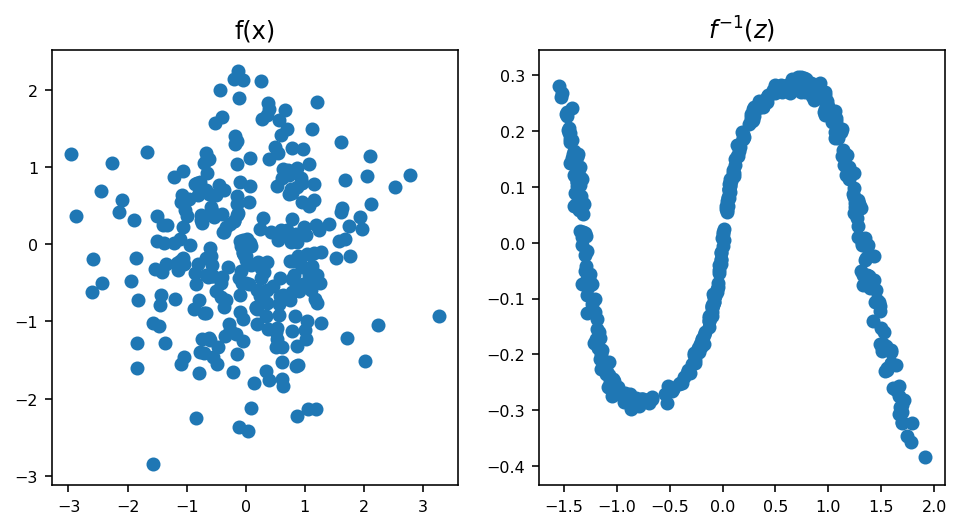

iter 4000: loss = -1.355


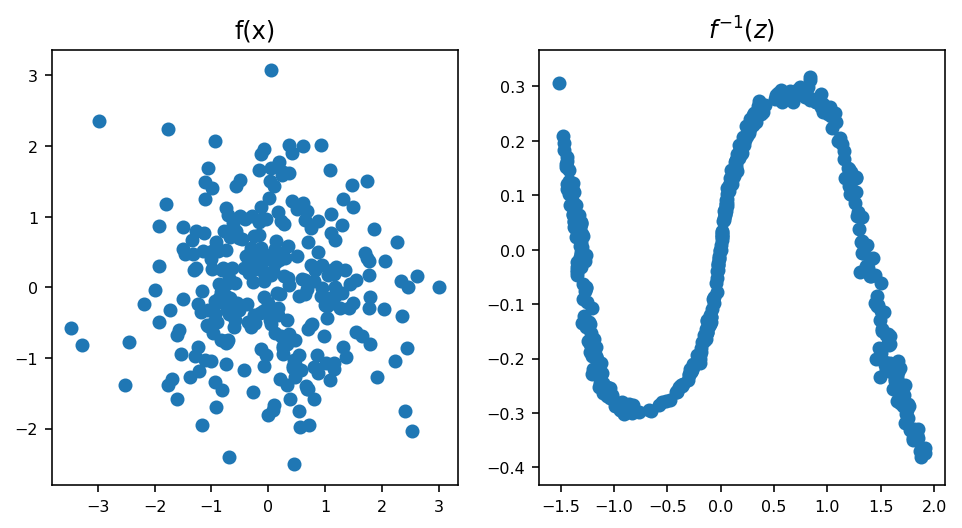

iter 4500: loss = -1.285


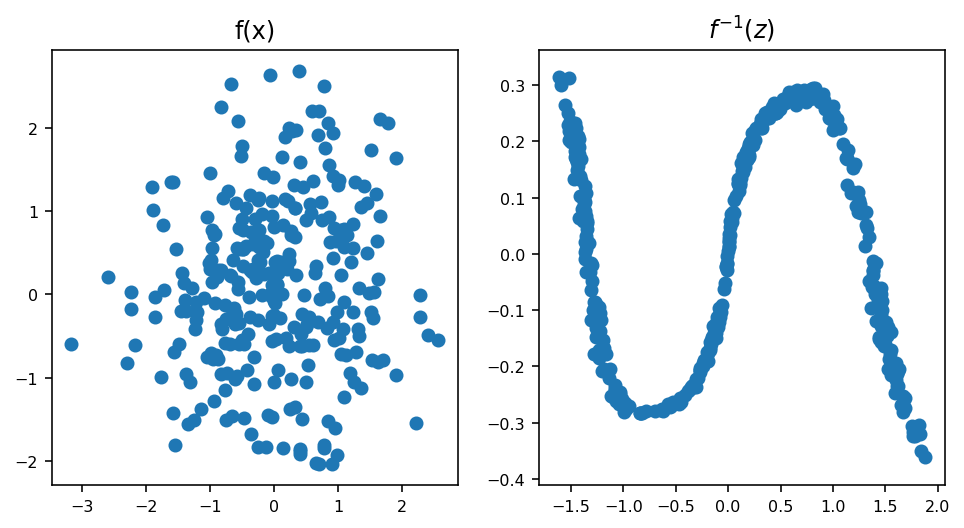

iter 5000: loss = -1.262


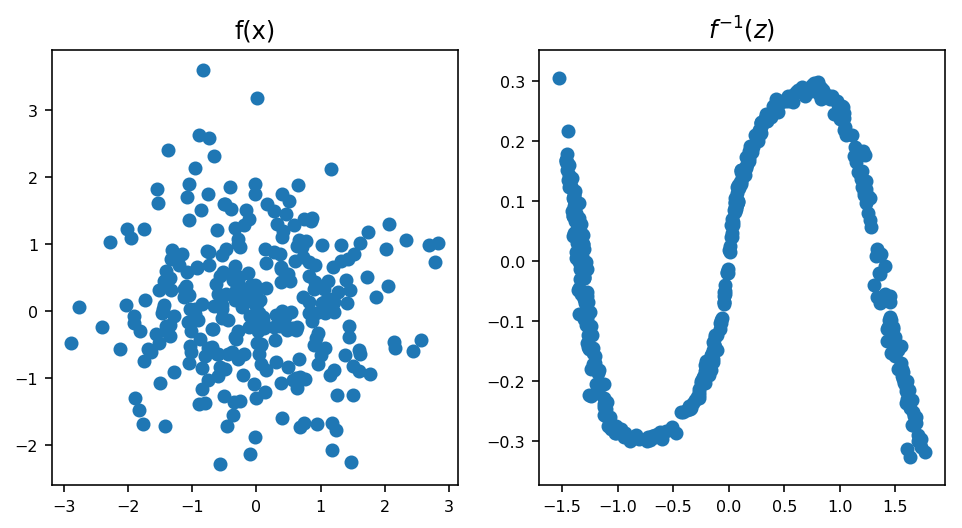

iter 5500: loss = -1.329


KeyboardInterrupt: 

In [209]:

for i in range(10000):

    sample = real_sample(N = 150, K = 2)
    z, logp = model(sample.float())
    
    if i % 500 == 0:
        zs = model(sample.float())[0].detach().numpy()
        test_x = model.sample(400).cpu().data.numpy()
        fig, [ax1,ax2]=plt.subplots(1,2,figsize=(8,4))
        ax1.scatter(zs[:,0], zs[:,1])
        ax1.set_title("f(x)")
        ax2.scatter(test_x[:,0],test_x[:,1])
        ax2.set_title(r"$f^{-1}(z)$")
        plt.show()
        
    loss = -logp.mean()
    
    if i % 500 == 0:
        print('iter %s:' % i, 'loss = %.3f' % loss)
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    


(-1.5, 2.5)

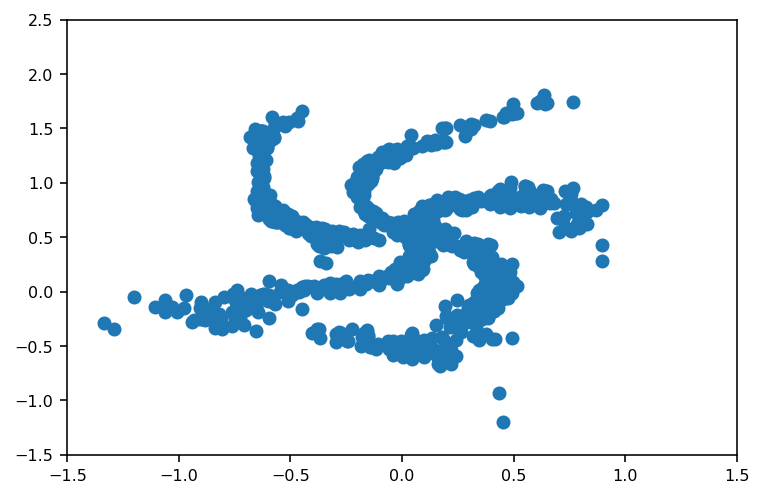

In [166]:
test_x = model.sample(1000).cpu().data.numpy()
plt.scatter(test_x[:,0],test_x[:,1])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,2.5)

In [96]:
### BACKUP

def mask(x):

    perm = torch.randperm(x.size(0))
    k = x.size(1) // 2
    idx1 = perm[:k]
    idx2 = perm[k:]
    x1 = x[idx1]
    x2 = x[idx2]
    
    return x1, x2, idx1,idx2

Text(0, 0.5, 'x2')

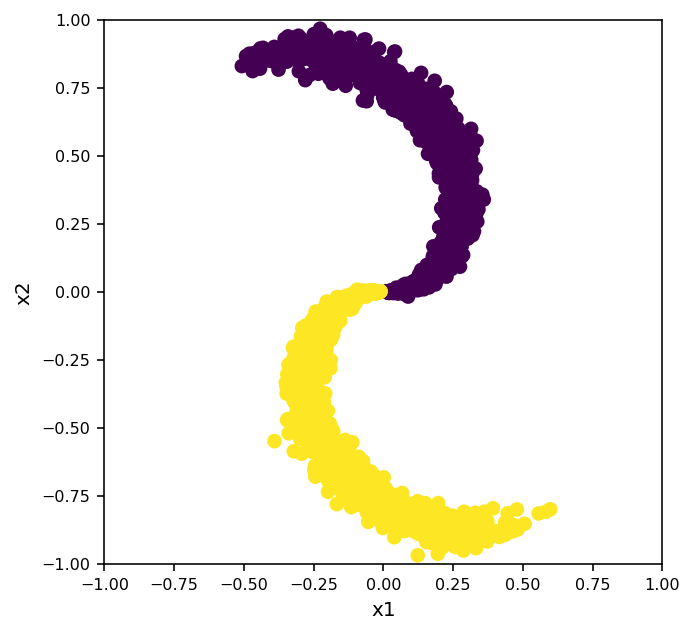

In [174]:
plt.rcParams['axes.labelsize']  = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

seed=1234
np.random.seed(seed)
#tf.set_random_seed(seed)

plt.ion() # turn on interactive mode (for plotting)


N = 1000 # number of points per branch
K = 2  # number of branches

N_train = N*K # total number of points in the training set
x_train = np.zeros((N_train,2)) # matrix containing the 2-dimensional datapoints
y_train = np.zeros(N_train, dtype='uint8') # labels (not in one-hot representation)

mag_noise = 0.1  # controls how much noise gets added to the data
dTheta    = 2   # difference in theta in each branch

### Data generation: ###
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.01,1,N) # radius
    t = np.linspace(j*(2*np.pi)/K,j*(2*np.pi)/K + dTheta,N) + np.random.randn(N)*mag_noise # theta
    x_train[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
    y_train[ix] = j

### Plot the data set: ###
fig = plt.figure(1, figsize=(5,5))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=40)#, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('x1')
plt.ylabel('x2')